In [1]:
# 필요 라이브러리 로딩
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

2.6.0


In [2]:
!mkdir -p ~/aiffel/medical
!ln -s ~/data/* ~/aiffel/medical

ln: failed to create symbolic link '/aiffel/aiffel/medical/ed_ckpt': File exists
ln: failed to create symbolic link '/aiffel/aiffel/medical/train': File exists
ln: failed to create symbolic link '/aiffel/aiffel/medical/train_labels': File exists
ln: failed to create symbolic link '/aiffel/aiffel/medical/unet_ckpt': File exists


In [3]:
DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical')

img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

In [4]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

In [5]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

In [6]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 240
Number of test examples: 60


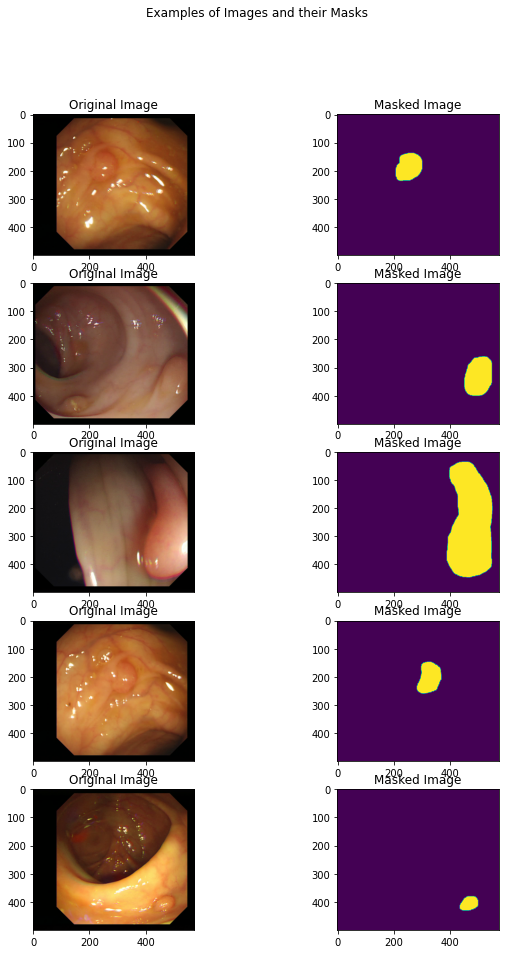

In [7]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")
    
plt.suptitle("Examples of Images and their Masks")
plt.show()

In [8]:
# Set hyperparameters

image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 8
max_epochs = 10

In [9]:
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=3)
    label_img = tf.image.rgb_to_grayscale(label_img)

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

In [10]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
                width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
                height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

In [11]:
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img

In [12]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,  # Random left right flip,
             width_shift_range=0.05,  # Randomly translate the image horizontally
             height_shift_range=0.05):  # Randomly translate the image vertically 
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
  
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

In [13]:
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:# 학습을 진행할시에만 위에 augment를 진행합니다.
        #if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        #  assert batch_size == 1, "Batching images must be of the same size"
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

In [14]:
train_dataset = get_baseline_dataset(x_train_filenames, # 학습 데이터
                                     y_train_filenames) # 정답 데이터
train_dataset = train_dataset.repeat()
test_dataset = get_baseline_dataset(x_test_filenames,
                                    y_test_filenames,
                                    is_train=False)
train_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

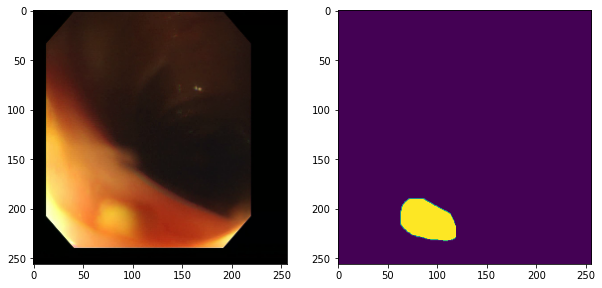

In [15]:
for images, labels in train_dataset.take(1):
    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

In [16]:
# inputs: [batch_size, 256, 256, 3]
encoder = tf.keras.Sequential(name='encoder')

# conv-batchnorm-activation-maxpool
encoder.add(layers.Conv2D(64, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv1: [batch_size, 128, 128, 64]

encoder.add(layers.Conv2D(128, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv2: [batch_size, 64, 64, 128]

encoder.add(layers.Conv2D(256, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(256, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv3: [batch_size, 32, 32, 256]

encoder.add(layers.Conv2D(512, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(512, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv4-outputs: [batch_size, 16, 16, 512]

In [17]:
# Encoder 제대로 만들어졌는지 확인

bottleneck = encoder(tf.random.normal([batch_size, 256, 256, 3]))
print(bottleneck.shape)   # (batch_size, 16, 16, 512) 이 나오는지 확인

(8, 16, 16, 512)


In [18]:
# inputs: [batch_size, 16, 16, 512]
decoder = tf.keras.Sequential(name='decoder')

# conv_transpose-batchnorm-activation
decoder.add(layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose1: [batch_size, 32, 32, 256]
decoder.add(layers.Conv2D(256, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose2: [batch_size, 64, 64, 128]
decoder.add(layers.Conv2D(128, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose3: [batch_size, 128, 128, 64]
decoder.add(layers.Conv2D(64, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv transpose4-outputs: [batch_size, 256, 256, 32]
decoder.add(layers.Conv2D(32, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(1, 1, strides=1, padding='same', activation='sigmoid'))

In [19]:
# decoder 제대로 만들어졌는지 확인

predictions = decoder(bottleneck)
print(predictions.shape)    # (batch_size, 256, 256, 1) 이 나오는지 확인

(8, 256, 256, 1)


In [20]:
ed_model = tf.keras.Sequential()

ed_model.add(encoder)
ed_model.add(decoder)

In [21]:
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)

        return x

In [22]:
class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters * 2, 3)

    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)

        return encoder

class ConvBlock_R(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)
        decoder = self.conv2(decoder, training=training)

        return decoder


class EncoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.MaxPool2D()

    def call(self, inputs, training=True):
        encoder = self.conv_block(inputs, training=training)
        encoder_pool = self.encoder_pool(encoder)

        return encoder_pool, encoder


class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.bn = layers.BatchNormalization()
        self.conv_block_r = ConvBlock_R(num_filters)

    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)            
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = tf.concat([decoder, concat_tensor], axis=-1)
        decoder = self.conv_block_r(decoder, training=training)

        return decoder

In [23]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_block1 = EncoderBlock(64)
        self.encoder_block2 = EncoderBlock(128)
        self.encoder_block3 = EncoderBlock(256)
        self.encoder_block4 = EncoderBlock(512)

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):
        encoder1_pool, encoder1 = self.encoder_block1(inputs)
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool)
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool)
        encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool)

        center = self.center(encoder4_pool)

        # *** 수정 전: skip connection 순서를 잘못 바꾸었음
        # *** 수정 후: 원래 U-Net 구조대로 복원
        decoder4 = self.decoder_block4(center, encoder4)   # 16x16
        decoder3 = self.decoder_block3(decoder4, encoder3) # 32x32
        decoder2 = self.decoder_block2(decoder3, encoder2) # 64x64
        decoder1 = self.decoder_block1(decoder2, encoder1) # 128x128 (정상적인 U-Net 구조 복원) # *** 수정 ***

        outputs = self.output_conv(decoder1)
        return outputs

In [24]:
unet_model = UNet()

In [25]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

In [26]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [27]:
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

In [28]:
optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용

In [29]:
# 위에서 구성한 두가지 모델 중에서 하나를 선택해 주세요. 
# 여기서 선택을 바꾸어 다른 모델의 학습도 진행해 볼 수 있습니다. 

#print('select the Encoder-Decoder model')
#model = ed_model
#checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/ed_model')

print('select the U-Net model')
model = unet_model
checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/unet_model')

select the U-Net model


In [30]:
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(8, 256, 256, 1)


In [31]:
model.summary()

Model: "u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_block (EncoderBlock) multiple                  76416     
_________________________________________________________________
encoder_block_1 (EncoderBloc multiple                  444288    
_________________________________________________________________
encoder_block_2 (EncoderBloc multiple                  1773312   
_________________________________________________________________
encoder_block_3 (EncoderBloc multiple                  7085568   
_________________________________________________________________
conv_block_4 (ConvBlock)     multiple                  28326912  
_________________________________________________________________
decoder_block (DecoderBlock) multiple                  18882048  
_________________________________________________________________
decoder_block_1 (DecoderBloc multiple                  354278

In [32]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [33]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

In [34]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

In [35]:
history = model.fit(train_dataset,
                    epochs=max_epochs,    # 10
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 39s 920ms/step - loss: 1.0526 - dice_loss: 0.7217 - val_loss: 16249.2979 - val_dice_loss: 0.9159
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
30/30 [==============================] - 29s 931ms/step - loss: 0.9087 - dice_loss: 0.6847 - val_loss: 42.5462 - val_dice_loss: 1.0000
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
30/30 [==============================] - 28s 907ms/step - loss: 0.9076 - dice_loss: 0.6881 - val_loss: 28.2637 - val_dice_loss: 1.0000
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
30/30 [==============================] - 29s 927ms/step - loss: 0.8894 - dice_loss: 0.6809 - val_loss: 3.8988

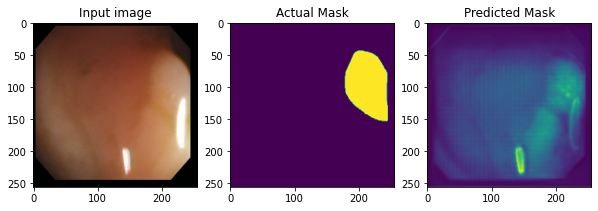

In [36]:
# print sample image after training
print_images()

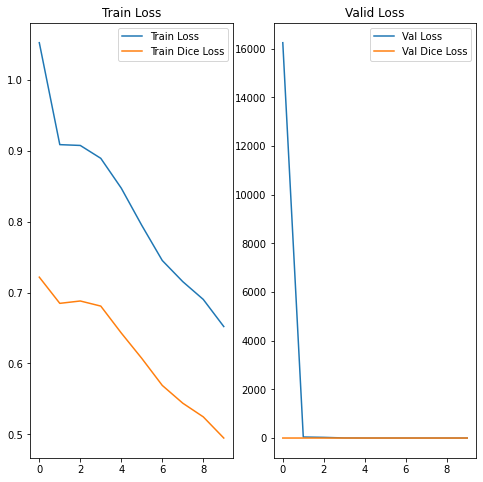

In [37]:
train_dice_loss = history.history['dice_loss']      # *** 수정 ***
train_loss = history.history['loss']
train_val_dice_loss = history.history['val_dice_loss']
train_val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(train_dice_loss, label='Train Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(train_val_loss, label='Val Loss')
plt.plot(train_val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

In [38]:
# 원하는 모델을 불러올 수 있도록 적절히 주석을 처리하세요
# checkpoint_dir = os.path.join(DATASET_PATH, 'ed_ckpt/ed_model')
checkpoint_dir = os.path.join(DATASET_PATH, 'unet_ckpt/unet_model')

# restoring the latest checkpoint in checkpoint_dir
model.load_weights(checkpoint_dir)

In [39]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [40]:
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.938717122127693


In [41]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

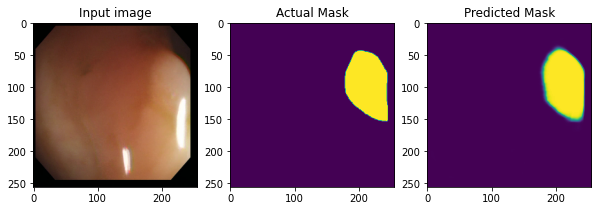

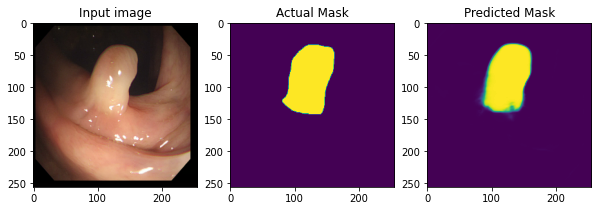

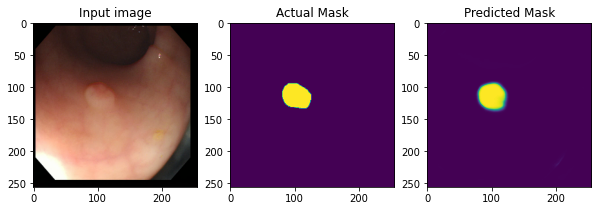

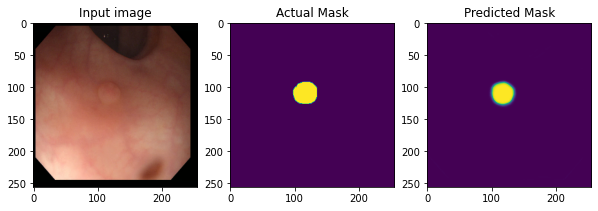

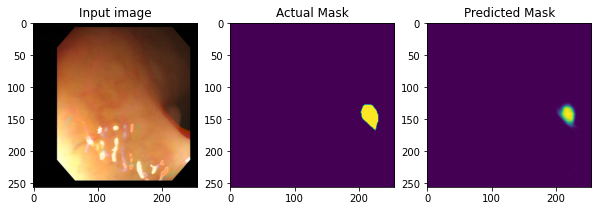

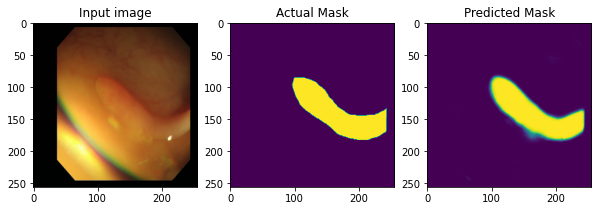

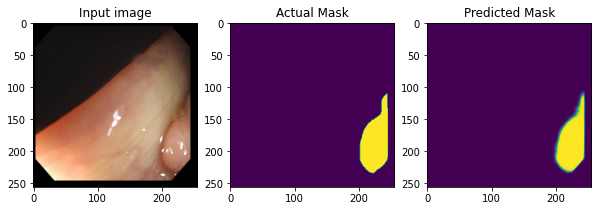

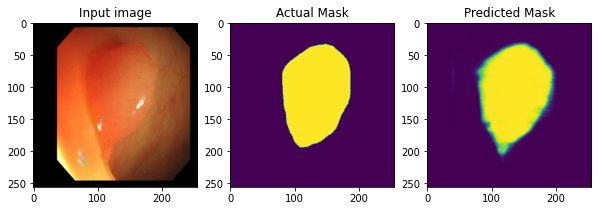

In [42]:
print_images()

In [57]:
#########################################################################
# 기존에 작성한 코드 하단에 추가하는 코드
#########################################################################

###########################################################
# step1 : Giana 데이터셋을 그대로 활용한 augmentation 파이프라인 구성
#         및 tf.data.Dataset을 통한 배치 처리
#
# 
#  - 기존 코드에서는 기본적인 augmentation(수평 뒤집기, 약간의 shift)만 적용
#  - 좀 더 다양한 augmentation을 적용하는 파이프라인을 구성
#  - 랜덤 회전, 밝기 조정, augmentation 기능 등 추가
#  - `_advanced_augment`를 통해 추가 augmentation을 수행
#  - augmentation 파이프라인을 통해 별도의 학습/테스트용 dataset을 생성
###########################################################

def _advanced_augment(img, label):
    # img, label: 전처리 완료된 이미지 텐서, 레이블 텐서가 입력된다.
    
    # 1) 랜덤 회전: -20~20도 사이 임의 회전
    # tf.image.rot90는 90도 단위 회전만 지원하므로, tfa.image.rotate 활용
    # 회전 각도는 라디안 단위를 사용하므로, 각도를 라디안으로 변환
    angle = tf.random.uniform([], -20, 20) * (3.14159265359 / 180.0)
    img = tfa.image.rotate(img, angle)
    label = tfa.image.rotate(label, angle)
    
    # 2) 밝기 조정: 랜덤하게 이미지 밝기를 약 ±20% 정도 변화
    img = tf.image.random_brightness(img, max_delta=0.2)
    
    # 3) 랜덤 대비 조정
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    
    # 4) 기존의 flip, shift 등의 간단한 augmentation도 적용 가능
    # 여기서는 수평 뒤집기만 추가적으로 적용
    flip_prob = tf.random.uniform([], 0.0, 1.0)
    img, label = tf.cond(tf.less(flip_prob, 0.5),
                         lambda: (tf.image.flip_left_right(img), tf.image.flip_left_right(label)),
                         lambda: (img, label))
    
    return img, label

def get_augmented_dataset(filenames, labels, batch_size=8, is_train=True):
    # 기존 get_baseline_dataset와 달리 advanced augmentation을 적용
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(_process_pathnames, num_parallel_calls=4) # 이미지 로딩 및 기본 resize/scale
    
    if is_train:
        dataset = dataset.map(_advanced_augment, num_parallel_calls=4)
        dataset = dataset.shuffle(len(filenames) * 2)
        
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# augmentation이 적용된 dataset 준비
aug_train_dataset = get_augmented_dataset(x_train_filenames, y_train_filenames, batch_size=batch_size, is_train=True)
aug_test_dataset = get_augmented_dataset(x_test_filenames, y_test_filenames, batch_size=batch_size, is_train=False)


###########################################################
# step2 : Pretrained model을 활용한 U-Net 모델 구성
#
# 설명:
#  - 일반적인 U-Net 모델에 사전학습(pretrained)된 백본(Encoder 부분)을 활용해볼 수 있다.
#  - 예를 들어, ImageNet으로 사전 학습된 ResNet, VGG, EfficientNet 등을 U-Net의 Encoder로 사용 가능.
#  - 여기서는 간단히 TensorFlow Hub나 tf.keras.applications에서 제공하는 
#    pretrained 모델(예: EfficientNetB0)을 encoder로 활용하는 U-Net 변형을 시도한다.
#
#  - 주의: pretrained encoder는 RGB scale이 다를 수 있으니, 전처리가 필요할 수 있다.
#    여기서는 scale 1/255로 통일했으므로 크게 문제 없지만, 필요시 추가 전처리 가능.
###########################################################

from tensorflow.keras.applications import EfficientNetB0

class PretrainedUNet(tf.keras.Model):
    def __init__(self):
        super(PretrainedUNet, self).__init__()
        from tensorflow.keras.applications import EfficientNetB0
        self.encoder = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3))
        
        # 선택 레이어:
        # block5a_activation: 16x16 -> encoder4
        # block3a_activation: 32x32 -> encoder2
        # block2a_activation: 64x64 -> encoder1
        self.stage_outputs = [
            'block5a_activation',  # encoder4 (16x16)
            'block3a_activation',  # encoder2 (32x32)
            'block2a_activation'   # encoder1 (64x64)
        ]
        
        self.encoder_outputs = [self.encoder.get_layer(name).output for name in self.stage_outputs]
        self.encoder_model = tf.keras.Model(inputs=self.encoder.input, outputs=self.encoder_outputs)
        
        self.center = ConvBlock(1024)
        
        # 디코더 블록
        self.decoder_block2 = DecoderBlock(256)  # 16x16 -> 32x32
        self.decoder_block1 = DecoderBlock(128)  # 32x32 -> 64x64
        self.decoder_block0 = DecoderBlock(64)   # 64x64 -> 128x128
        self.decoder_block_final = DecoderBlock(32) # 128x128 -> 256x256 (마지막 업샘플)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')
        
    def call(self, inputs, training=True):
        encoder4, encoder2, encoder1 = self.encoder_model(inputs, training=training)

        # center (16x16)
        center = self.center(encoder4, training=training)
        
        # 16x16 -> 32x32
        decoder2 = self.decoder_block2(center, encoder2, training=training)
        # 32x32 -> 64x64
        decoder1 = self.decoder_block1(decoder2, encoder1, training=training)
        # 64x64 -> 128x128 (skip 없음)
        decoder = self.decoder_block0.convT(decoder1)
        decoder = self.decoder_block0.bn(decoder, training=training)
        decoder = tf.nn.relu(decoder)
        dummy_skip = tf.zeros_like(decoder)
        decoder = tf.concat([decoder, dummy_skip], axis=-1)
        decoder = self.decoder_block0.conv_block_r(decoder, training=training)

        # 마지막 업샘플: 128x128 -> 256x256 (skip 없음)
        decoder = self.decoder_block_final.convT(decoder)
        decoder = self.decoder_block_final.bn(decoder, training=training)
        decoder = tf.nn.relu(decoder)
        dummy_skip_2 = tf.zeros_like(decoder)
        decoder = tf.concat([decoder, dummy_skip_2], axis=-1)
        decoder = self.decoder_block_final.conv_block_r(decoder, training=training)

        outputs = self.output_conv(decoder)  # 최종 256x256 shape
        return outputs

pretrained_unet_model = PretrainedUNet()
pretrained_unet_model.encoder.trainable = True

# BatchNormalization 레이어를 훈련 모드로 설정
for layer in pretrained_unet_model.encoder.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

In [59]:
# EfficientNet의 모든 레이어 Unfreeze
for layer in pretrained_unet_model.encoder.layers:
    layer.trainable = True

In [60]:
sample_input = tf.random.normal([1, 256, 256, 3])
enc_outs = pretrained_unet_model.encoder_model(sample_input, training=False)
for i, out in enumerate(enc_outs):
    print(f"Encoder output {i} shape:", out.shape)

Encoder output 0 shape: (1, 16, 16, 480)
Encoder output 1 shape: (1, 32, 32, 144)
Encoder output 2 shape: (1, 64, 64, 96)


Training Encoder-Decoder Model with augmented dataset...
Epoch 1/10
30/30 [==============================] - 10s 219ms/step - loss: 0.4148 - dice_loss: 0.3124 - val_loss: 0.7137 - val_dice_loss: 0.5058
Epoch 2/10
30/30 [==============================] - 8s 210ms/step - loss: 0.3715 - dice_loss: 0.2770 - val_loss: 0.6347 - val_dice_loss: 0.5053
Epoch 3/10
30/30 [==============================] - 8s 212ms/step - loss: 0.3889 - dice_loss: 0.2911 - val_loss: 1.0185 - val_dice_loss: 0.8342
Epoch 4/10
30/30 [==============================] - 8s 214ms/step - loss: 0.3628 - dice_loss: 0.2705 - val_loss: 0.4411 - val_dice_loss: 0.3451
Epoch 5/10
30/30 [==============================] - 8s 211ms/step - loss: 0.3990 - dice_loss: 0.2992 - val_loss: 0.5148 - val_dice_loss: 0.4172
Epoch 6/10
30/30 [==============================] - 8s 208ms/step - loss: 0.3477 - dice_loss: 0.2582 - val_loss: 0.5811 - val_dice_loss: 0.4758
Epoch 7/10
30/30 [==============================] - 8s 208ms/step - loss: 0.35

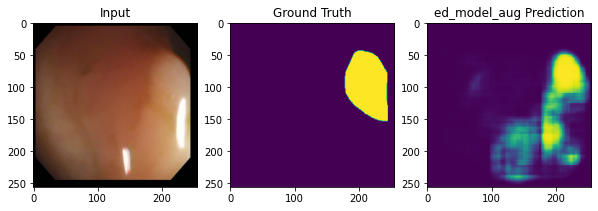

Training U-Net Model with augmented dataset...
Epoch 1/10
30/30 [==============================] - 32s 955ms/step - loss: 0.1036 - dice_loss: 0.0749 - val_loss: 0.1959 - val_dice_loss: 0.1442
Epoch 2/10
30/30 [==============================] - 29s 921ms/step - loss: 0.1184 - dice_loss: 0.0850 - val_loss: 0.1630 - val_dice_loss: 0.1224
Epoch 3/10
30/30 [==============================] - 29s 930ms/step - loss: 0.0987 - dice_loss: 0.0716 - val_loss: 0.1582 - val_dice_loss: 0.1181
Epoch 4/10
30/30 [==============================] - 29s 929ms/step - loss: 0.0970 - dice_loss: 0.0710 - val_loss: 0.1846 - val_dice_loss: 0.1398
Epoch 5/10
30/30 [==============================] - 29s 927ms/step - loss: 0.0892 - dice_loss: 0.0636 - val_loss: 0.1338 - val_dice_loss: 0.1005
Epoch 6/10
30/30 [==============================] - 29s 917ms/step - loss: 0.0980 - dice_loss: 0.0716 - val_loss: 0.1315 - val_dice_loss: 0.1008
Epoch 7/10
30/30 [==============================] - 30s 943ms/step - loss: 0.0913 -

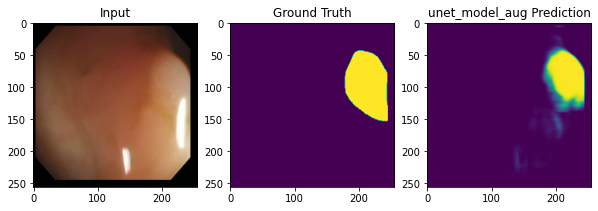

Training Pretrained U-Net Model with augmented dataset...
Epoch 1/10
30/30 [==============================] - 17s 348ms/step - loss: 0.1868 - dice_loss: 0.1303 - val_loss: 1.1106 - val_dice_loss: 0.9278
Epoch 2/10
30/30 [==============================] - 11s 317ms/step - loss: 0.1479 - dice_loss: 0.1052 - val_loss: 1.2396 - val_dice_loss: 0.9920
Epoch 3/10
30/30 [==============================] - 11s 323ms/step - loss: 0.1203 - dice_loss: 0.0857 - val_loss: 1.2123 - val_dice_loss: 0.9860
Epoch 4/10
30/30 [==============================] - 11s 325ms/step - loss: 0.1043 - dice_loss: 0.0741 - val_loss: 1.2595 - val_dice_loss: 0.9947
Epoch 5/10
30/30 [==============================] - 11s 323ms/step - loss: 0.0997 - dice_loss: 0.0712 - val_loss: 0.9572 - val_dice_loss: 0.7766
Epoch 6/10
30/30 [==============================] - 11s 315ms/step - loss: 0.0957 - dice_loss: 0.0685 - val_loss: 1.2672 - val_dice_loss: 0.9956
Epoch 7/10
30/30 [==============================] - 11s 316ms/step - los

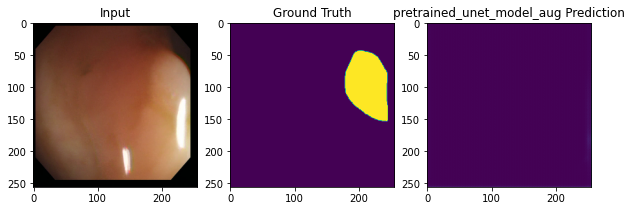

Comparison of Three Models:
Encoder-Decoder mean IoU: 0.7328104683741152
U-Net mean IoU:          0.8787917462749808
Pretrained U-Net mean IoU:0.478665828704834


In [63]:
###########################################################
# step3 : 모델 변경 후 기존 학습/테스트, 시각화 과정 수행
#  - 기존 Encoder-Decoder 모델, 기본 U-Net 모델, 그리고 Pretrained U-Net 모델
#    3가지를 모두 학습 및 테스트
#  - 여기서는 시간이 오래 걸릴 수 있으므로 epoch 수를 줄이거나, 간단히 학습하는 과정을 예시로 보여 줌
#  - 또한 세 모델 모두 동일한 파이프라인(aug_train_dataset, aug_test_dataset)으로 학습
#  - 학습 후 동일한 테스트 이미지에 대한 시각화 비교를 통해 성능 차이를 정성적으로 평가
###########################################################

# 학습 관련 함수 재활용
# - 기존 model compile, fit, plot 및 evaluation 로직을 재사용
# - 모델만 변경해서 실험 진행
# - Encoder-Decoder 모델, U-Net 모델, Pretrained U-Net 모델 각각 학습

def train_and_evaluate(model, train_dataset, test_dataset, model_name='model', epochs=10):
    # 컴파일
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=bce_dice_loss,
                  metrics=[dice_loss])
    
    # 체크포인트 경로
    ckpt_dir = os.path.join(DATASET_PATH, 'train_ckpt', model_name)
    if not os.path.isdir(ckpt_dir):
        os.makedirs(ckpt_dir)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(ckpt_dir,
                                                     save_weights_only=True,
                                                     monitor='val_loss',
                                                     mode='auto',
                                                     save_best_only=True,
                                                     verbose=0)
    
    # 학습
    history = model.fit(train_dataset,
                        epochs=epochs,
                        steps_per_epoch=num_train_examples//batch_size,
                        validation_data=test_dataset,
                        validation_steps=num_test_examples//batch_size,
                        callbacks=[cp_callback])
    
    # 평가
    # mean_iou 계산
    mean_ious = []
    for images, labels in test_dataset:
        preds = model(images, training=False)
        miou = mean_iou(labels, preds)
        mean_ious.append(miou)
    mean_iou_score = np.mean(mean_ious)
    print(f"{model_name} mean_iou: {mean_iou_score}")
    
    # 시각화
    for test_images, test_labels in test_dataset.take(1):
        preds = model(test_images, training=False)
        i = 0  # 첫번째 이미지만 표시
        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[i])
        plt.title("Input")
        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[i,:,:,0])
        plt.title("Ground Truth")
        plt.subplot(1, 3, 3)
        plt.imshow(preds[i,:,:,0])
        plt.title(f"{model_name} Prediction")
        plt.show()
    
    return history, mean_iou_score

# 1) Encoder-Decoder 모델 학습 & 평가
print("Training Encoder-Decoder Model with augmented dataset...")
ed_model_hist, ed_model_miou = train_and_evaluate(ed_model, aug_train_dataset, aug_test_dataset, 'ed_model_aug', epochs=10)

# 2) U-Net 모델 학습 & 평가
print("Training U-Net Model with augmented dataset...")
unet_model_hist, unet_model_miou = train_and_evaluate(unet_model, aug_train_dataset, aug_test_dataset, 'unet_model_aug', epochs=10)

# 3) Pretrained U-Net 모델 학습 & 평가
print("Training Pretrained U-Net Model with augmented dataset...")
pretrained_unet_model_hist, pretrained_unet_model_miou = train_and_evaluate(pretrained_unet_model, aug_train_dataset, aug_test_dataset, 'pretrained_unet_model_aug', epochs=10)


###########################################################
# step4 : 3가지 모델에 대한 학습 진행과정 및 정량/정성적 결과 비교분석
#
# 설명:
#  - step3에서 얻은 세 가지 모델(Encoder-Decoder, U-Net, Pretrained U-Net) 결과를 비교.
#  - 각 모델의 mean_iou(정량적 평가) 점수를 비교.
#  - 또한 시각화된 결과(정성적 평가) 비교.
#  - 실제 분석과정은 주석으로 기술.
###########################################################

print("====================================")
print("Comparison of Three Models:")
print(f"Encoder-Decoder mean IoU: {ed_model_miou}")
print(f"U-Net mean IoU:          {unet_model_miou}")
print(f"Pretrained U-Net mean IoU:{pretrained_unet_model_miou}")
print("====================================")

# 정량적 비교:
# - mean IoU 점수를 통해 성능 비교.
# - 일반적으로 pretrained encoder를 활용한 U-Net이 더 풍부한 표현력을 가지므로,
#   mean IoU가 더 높게 나올 것으로 기대할 수 있다.
# - 만약 결과가 그렇지 않다면, 하이퍼파라미터 조정, pretrained 모델 선택 변경, 추가적인 데이터 증강을 고려할 수 있다.

# 정성적 비교:
# - 각 모델별 예측 마스크 시각화를 통해 실제로 경계나 형태를 더 정확히 복원하는지, 노이즈가 적은지 등을 관찰할 수 있다.
# - pretrained U-Net 모델의 경우 사전학습된 Feature Extractor를 활용했으므로
#   초기 학습시에도 비교적 빠르게 수렴하며, 보다 부드러운 예측을 내놓을 것으로 예상.

# 여기서 제안한 분석:
# 1) mean IoU 지표 비교: 단일 숫자로 모델 성능 측정.
# 2) 학습 곡선 비교: 각 model_hist.history를 통해 loss, val_loss, dice_loss 변화를 비교해도 된다.
# 3) 추출된 예측 결과 이미지 비교: 경계선이 더 뚜렷하고 노이즈가 적은지 관찰.

# 이 과정을 통해 세 가지 모델(Encoder-Decoder, U-Net, Pretrained U-Net) 간의 장단점을 이해하고,
# 향후 모델 선택과 개선 방향을 잡을 수 있다.